# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

## 0 Prerequisites

### 0.0 Import packages and ModelClass

In [108]:
%load_ext autoreload
%autoreload 2

# standard packages
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

# local modules
import figs
import analyse as ana
import validate
from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Import data for equivalence scale and life cycle income profile

In [79]:
# read data
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

## 1 Baseline model

In [106]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'nu':0.3,
        'thetab':250,
        'K':8.8,  
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 79.8 secs
 t = 2 solved in 66.2 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 90.2 secs
 total stay-time  = 13.4 secs
 total ref-time   = 17.7 secs
 total buy-time   = 12.8 secs
 total rent-time   = 11.8 secs
 full model solved in = 146.0 secs
model simulated in 59.4 secs
numba precompiled in 212.4 secs
 last period bequest computed in 0.1 secs
 solved stayer problem in 0.2 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.3 secs
 v_bar and q computed in 1.3 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.6 secs
 v_bar and q computed in 1.6 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.7 secs
 v_bar and q compute

### 1.0 Decision Functions

In [56]:
figs.decision_functions(model_baseline)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### 1.1 Life Cycle Behaviour

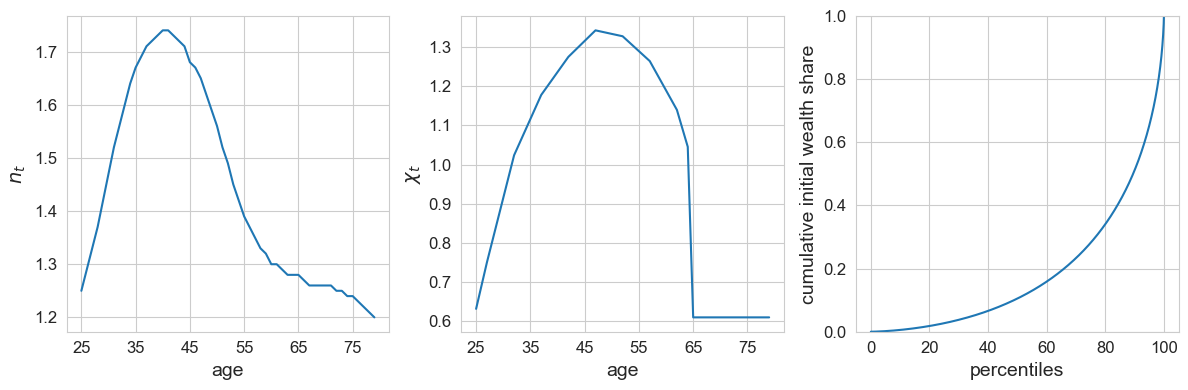

In [84]:
# plot calibration inputs
figs.n_chi_iniwealth(model_baseline,data)

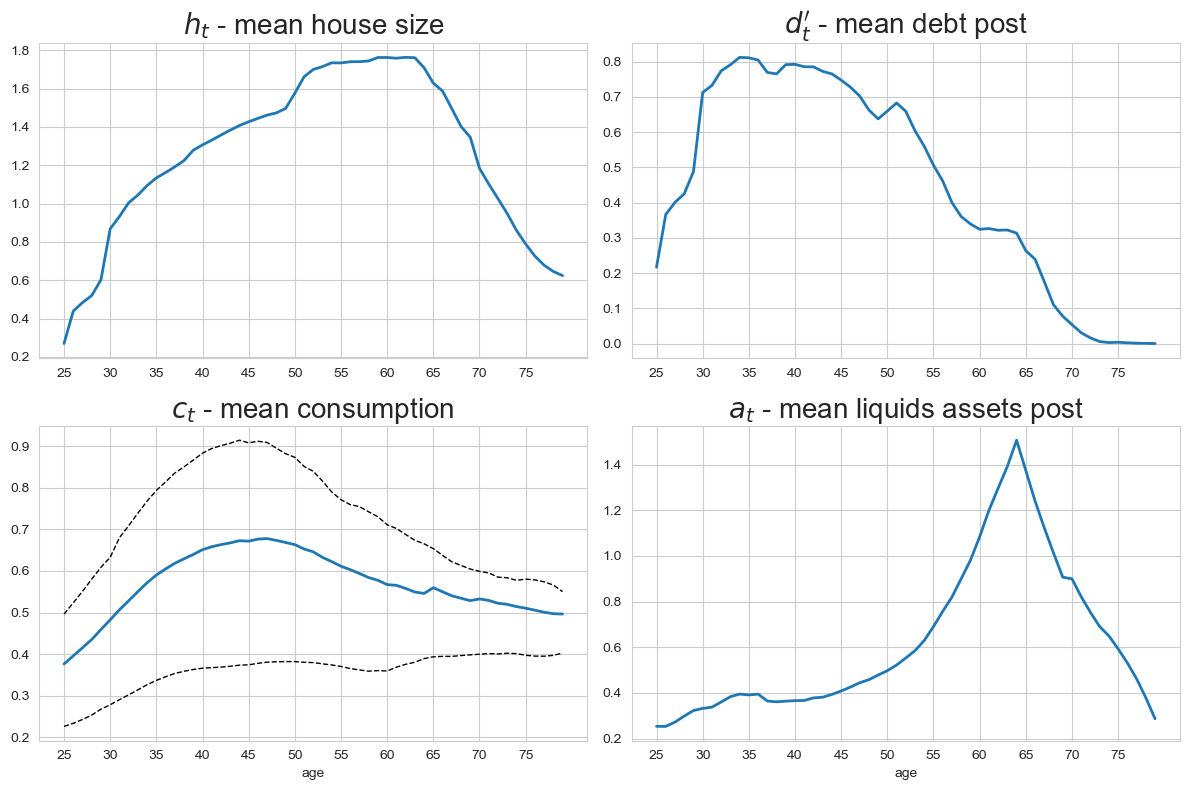

In [85]:
# average behaviour over the life cycle
figs.lifecycle_full(model_baseline)

### 1.2 Compare with data

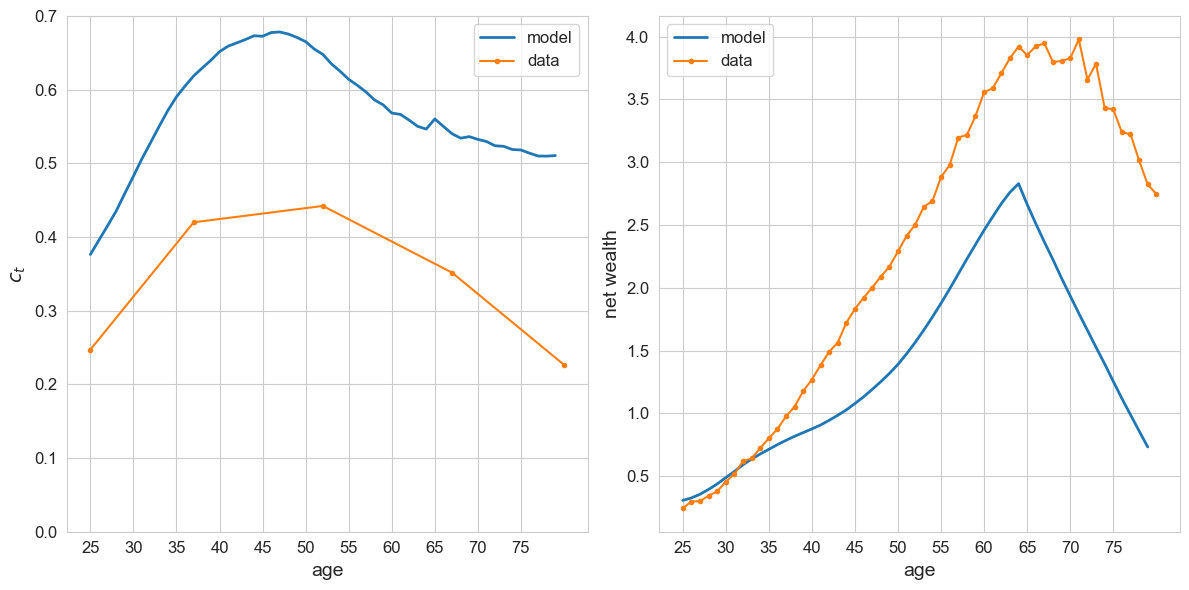

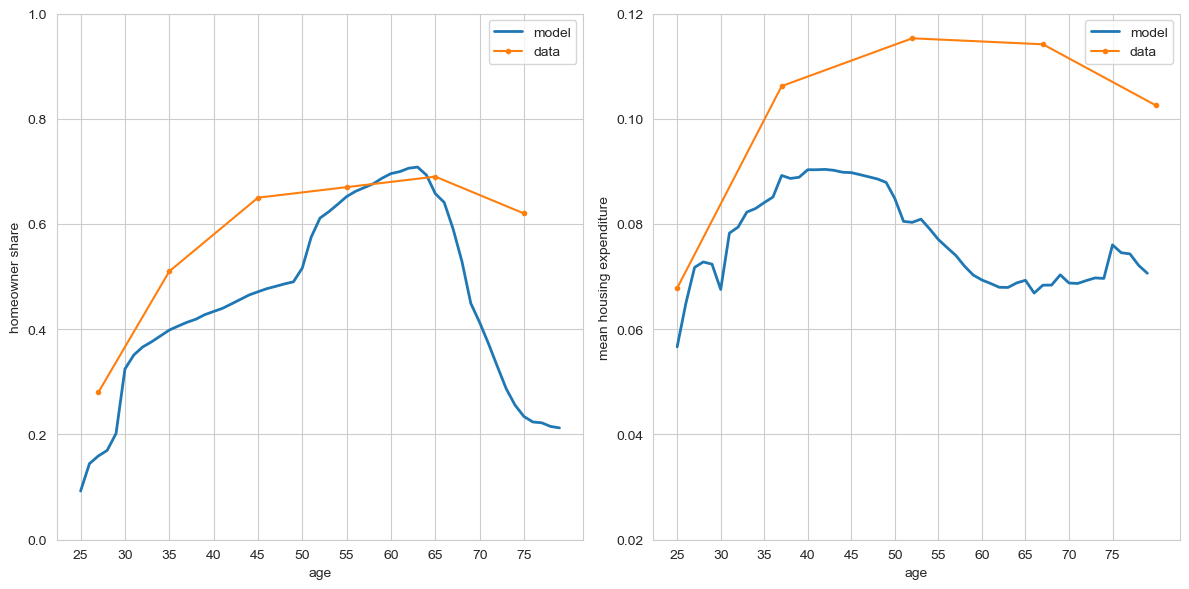

/Users/Christian/Dropbox/KU - Polit/KA/Thesis/MScThesis-2022/figs.py:375: RuntimeWarning: invalid value encountered in true_divide
  sheet_name='MortgageOutput').to_numpy()


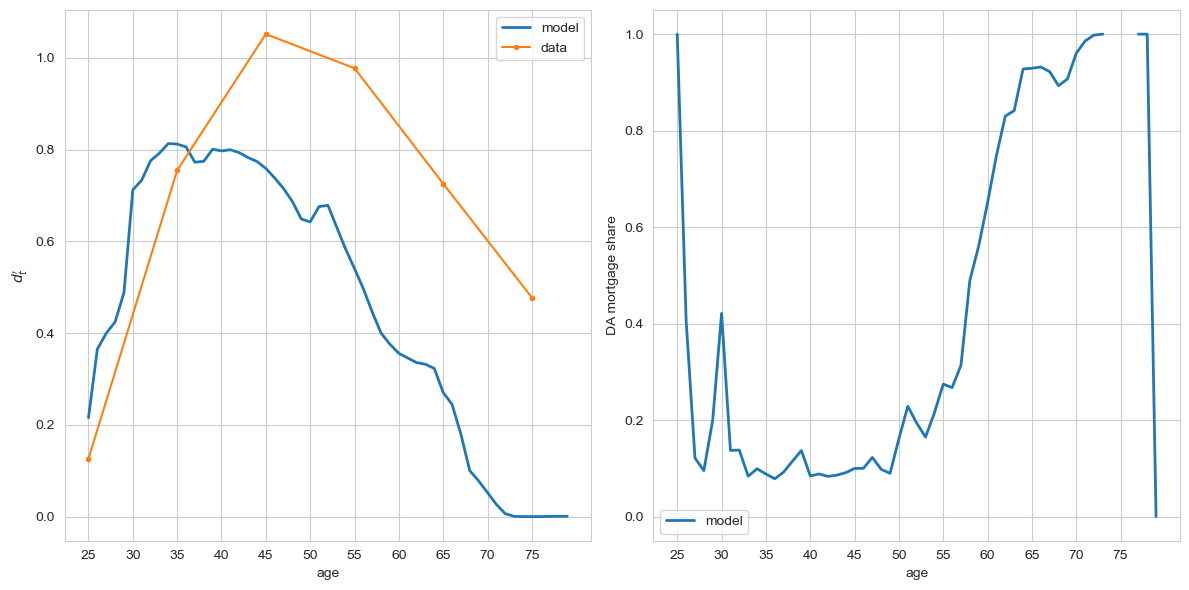

In [125]:
figs.lifecycle_consav(model_baseline)
figs.lifecycle_housing(model_baseline)
figs.lifecycle_mortgage(model_baseline)

### 1.3 Validate simulation

In [110]:
validate.val_sim(model_baseline)

there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting
there are no errors in housing stock


In [116]:
validate.val_finreg(model_baseline)

average mortgage size at origination is 2.1798
the share of DA mortgages at origination is 1.0000
mean LTV is 0.7988 and mean DTI is 1.2756 at mortgage origination


In [122]:
validate.val_inc_calib_targets(model_baseline)

taxes to labour income is 0.3537
median pre tax income is 0.6097
mean property tax is 0.0120
mean pre tax income is 1.0058


### 1.4 Aggregate moments 

In [123]:
# targeted model moments
names_targ, moments_targ = ana.model_moments_targ(model_baseline)
print('Targeted moments from baseline model:')
for i in range(len(names_targ)):
    print(f'  {names_targ[i]} = {moments_targ[i]:.4f}')

Targeted moments from baseline model:
  Aggregate net worth / (annual) labour income = 1.3766
  Annual fraction of houses sold = 0.0513
  Home ownership rate of <35 y.o. = 0.2573
  Mean NW at age 75 / mean NW at age 55/50 = 0.6684
  Share of households leaving no bequest = 0.6014
  Taxes to labour income = 0.3537


In [124]:
# untargeted model moments
names, moments = ana.model_moments(model_baseline)
print('Untargeted moments from baseline model:')
for i in range(len(names)):
    print(f'  {names[i]} = {moments[i]:.4f}')

Untargeted moments from baseline model:
  Homeowner share = 0.4497
  Mean house size = 2.7672
  Average housing expenditure = 0.0770
  Mean mortgage size = 1.7277
  Share of homeowners with mortgage = 0.5921
  DA mortgage share = 0.2793
  Average LTV ratio = 0.7289
  Average DTI ratio = 1.2303
  Gini coefficient = 0.7159


### 1.5 Discrete choices over the lifecycle

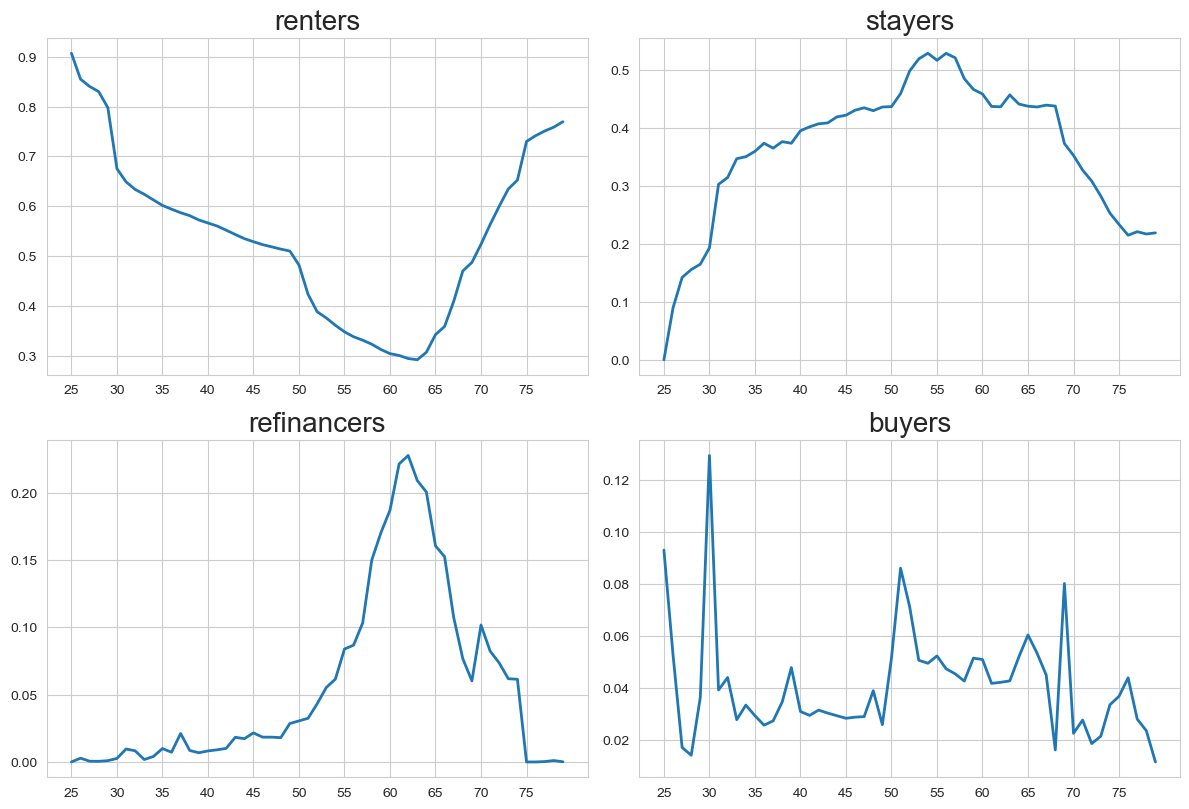

In [103]:
figs.homeownership(model_baseline)

### 1.6 Inspect the life cycle profile of a given household

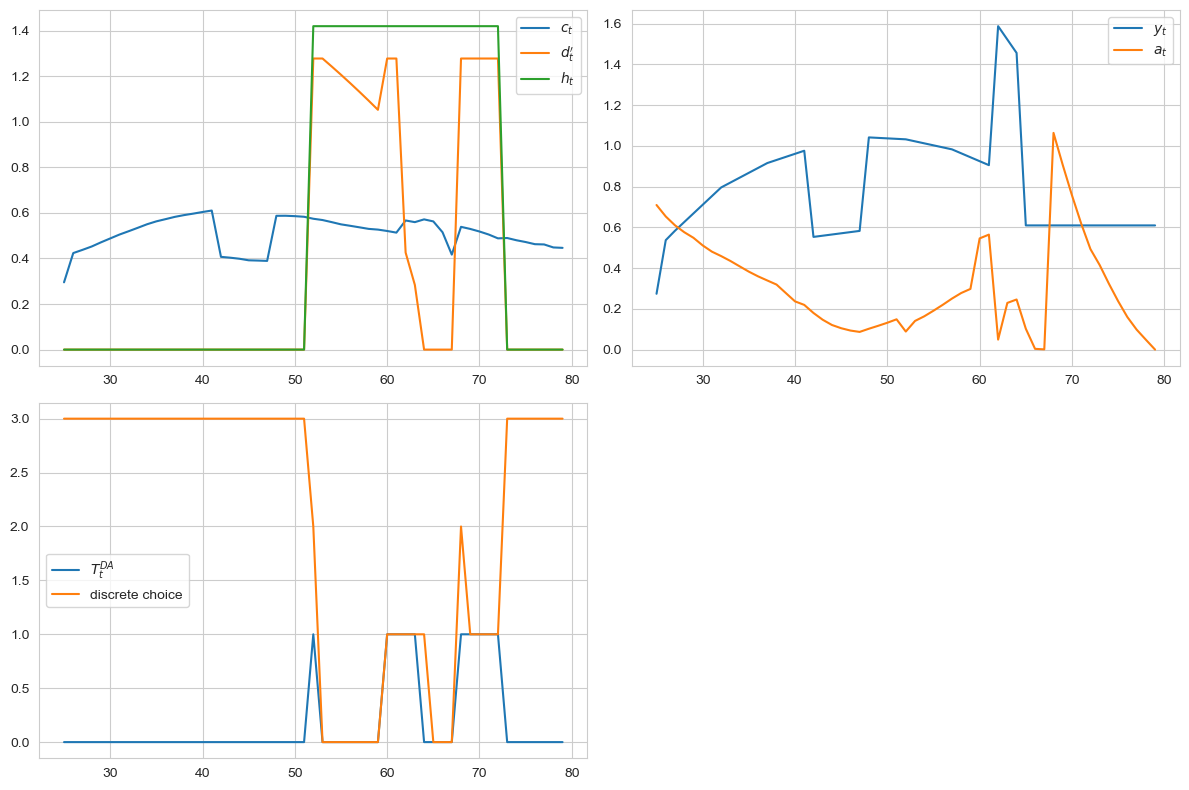

In [74]:
figs.example_household(model_baseline,hh_no=50_000)

## 2 Model without interest rate deduction - no change in house price

In [129]:
# initialise an instance of baseline model
model_nodeduct = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'nu':0.3,
        'thetab':250,
        'K':8.8,  
        'C_buy':0.0, 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15,
        'tau_r0':0.0,
        'tau_r1':0.0
        })

model_nodeduct.precompile_numba() # solve model with very coarse grids --> speed gains
model_nodeduct.solve()
model_nodeduct.simulate()

 t = 3 solved in 75.4 secs
 t = 2 solved in 46.7 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 62.8 secs
 total stay-time  = 22.5 secs
 total ref-time   = 14.5 secs
 total buy-time   = 13.0 secs
 total rent-time   = 9.3 secs
 full model solved in = 122.1 secs
model simulated in 60.7 secs
numba precompiled in 187.0 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.1 secs
 v_bar and q computed in 1.1 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.2 secs
 v_bar and q computed in 1.3 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.5 secs
 v_bar and q computed

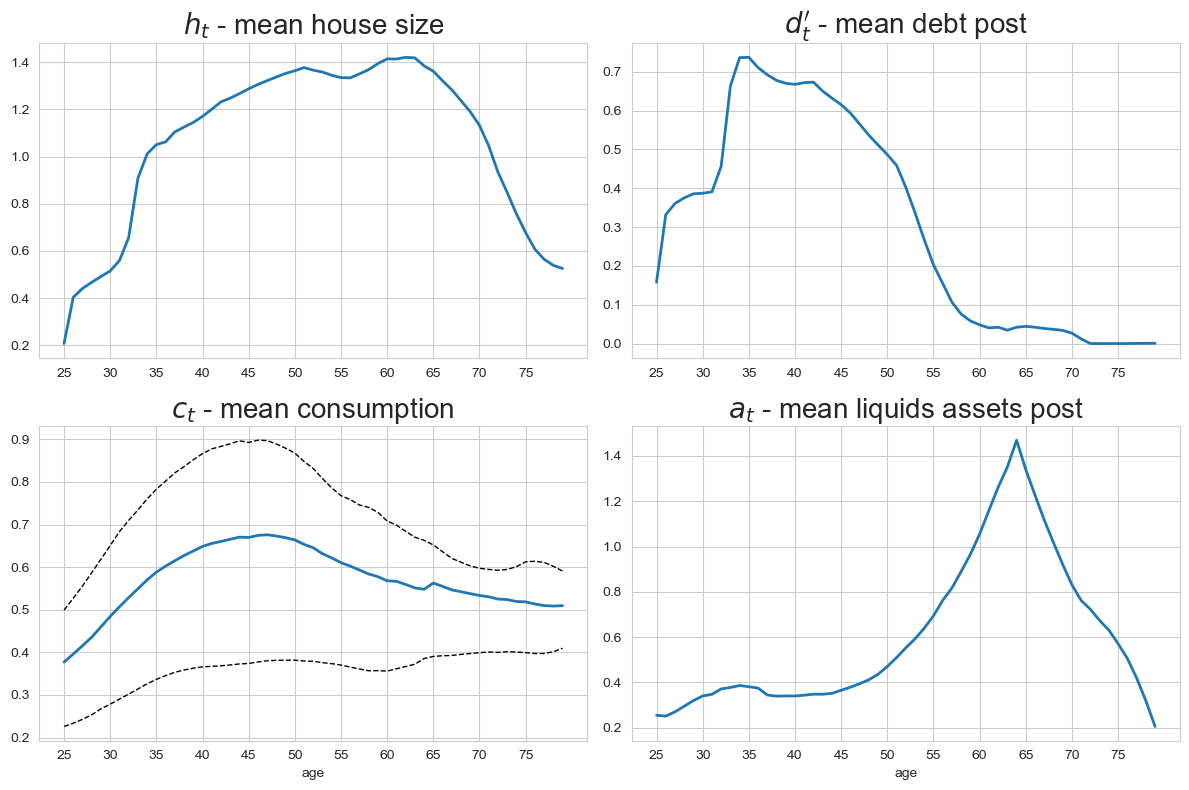

In [130]:
figs.lifecycle_full(model_nodeduct)

### 2.0 Aggregate moments in alternative model

In [131]:
names_targ_nd, moments_targ_nd = ana.model_moments_targ(model_nodeduct)
print('Targeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_targ_nd)):
    print(f'  {names_targ_nd[i]} = {moments_targ_nd[i]:.4f}')

Targeted moments from baseline model without interest rate deductibility:
  Aggregate net worth / (annual) labour income = 1.3534
  Annual fraction of houses sold = 0.0382
  Home ownership rate of <35 y.o. = 0.1763
  Mean NW at age 75 / mean NW at age 55/50 = 0.6834
  Share of households leaving no bequest = 0.6060
  Taxes to labour income = 0.3557


In [132]:
names_nd, moments_nd = ana.model_moments(model_nodeduct)
print('Untargeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_nd)):
    print(f'  {names_nd[i]} = {moments_nd[i]:.4f}')

Untargeted moments from baseline model without interest rate deductibility:
  Homeowner share = 0.3440
  Mean house size = 3.1005
  Average housing expenditure = 0.0780
  Mean mortgage size = 1.9372
  Share of homeowners with mortgage = 0.4594
  DA mortgage share = 0.2294
  Average LTV ratio = 0.6712
  Average DTI ratio = 1.1068
  Gini coefficient = 0.7271


### 2.1 Consumption equivalent variation between baseline and alternative

In [180]:
model_baseline.simulate(do_utility=True)
model_nodeduct.simulate(do_utility=True)

model simulated in 70.7 secs
utility calculated in 8.2 secs
model simulated in 64.5 secs
utility calculated in 10.9 secs


In [181]:
print(len(np.unique(model_baseline.sim.utility)))
print(len(np.unique(model_nodeduct.sim.utility)))

15081
34612


In [182]:
print(np.sum(np.isinf(model_baseline.sim.utility)))
print(np.sum(np.isinf(model_nodeduct.sim.utility)))
print(np.sum(np.isinf(u)))

84920
65389


In [191]:
import utility
from EconModel import jit
from numba import njit, prange
with jit(model_baseline) as model:
    par = model.par
    sim = model.sim

@njit(parallel=True)
def calc_u(sim,par):
    u = np.zeros(par.simN)
    for t in range(par.T):
        for i in prange(par.simN):
            # stayers and refinancers
            if sim.discrete[t,i] in [0,1]: 
                move = 0
                rent = 0
                u[i] += par.beta**t*utility.func(sim.c[t,i],sim.h_prime[t,i],move,rent,t,par)
            ## refinancers
            #elif sim.discrete[t,i] == 1:
            #    move = 0
            #    rent = 0
            #    u[n] += par.beta**t*utility.func(sim.c[t,i],sim.h_prime[t,i],move,rent,t,par)
            #  buyers
            elif sim.discrete[t,i] == 2:
                move = 1
                rent = 0
                u[i] += par.beta**t*utility.func(sim.c[t,i],sim.h_prime[t,i],move,rent,t,par)
            # renters
            elif sim.discrete[t,i] == 3:
                move = 0
                rent = 1
                u[i] += par.beta**t*utility.func(sim.c[t,i],sim.h_tilde[t,i],move,rent,t,par)
            if u[i] == -np.inf:
                print(t,i)
                break
    return u
u_baseline = calc_u(sim,par)

In [194]:
with jit(model_nodeduct) as model:
    par = model.par
    sim = model.sim

u_nodeduct = calc_u(sim,par)

In [195]:
print(len(np.unique(u_baseline)))
print(np.sum(np.isinf(u_baseline)))

print(len(np.unique(u_nodeduct)))
print(np.sum(np.isinf(u_nodeduct)))

100000
0
100000
0


In [206]:
model_baseline.sim.utility = u_baseline
model_nodeduct.sim.utility = u_nodeduct

import analyse as ana 

with jit(model_baseline) as model:
    par1 = model.par
    sim1 = model.sim

with jit(model_nodeduct) as model:
    par2 = model.par
    sim2 = model.sim

cev = ana.cev(sim1,sim2,par1,par2)
cev[0:100]
#fig = plt.figure(figsize=(8,6))
#ax = fig.add_subplot(111)
#ax.hist(cev,bins=500)
#ax.set_xlabel('consumption equivalent variation')
#ax.set_ylabel('frequency')

### Loop to match bequest level with initial wealth

In [77]:
# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# find mean bequest for initial guess
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')
print(f'average hh pre-tax income is {np.mean(sim.y)*670_000:.4f}')

initial wealth is 30058.3249
total bequest is 57569.7273
mean bequest is 0.5757
average hh pre-tax income is 673864.9715


In [ ]:
import steady_state
steady_state.bequest_loop(model_baseline,ab_mean)

### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [ ]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')


In [ ]:
from EconModel import jit
import utility

# a. unpack
with jit(model_baseline) as model:
    par = model_baseline.par
    sim = model_baseline.sim 

# b. check utility function
c = 1
h = 1
move = 0 
rent = 1
t = 20
n = par.n[t]
nu = 0.4
alpha = 1.1
s = (1-rent)*h/n + par.phi*rent*h/n
print(f' rent utility is {utility.func(c,h,move,rent,t,par)}')
print(f' own utility is {utility.func(c,h,move,0,t,par)}')
print(f' diff is {utility.func(c,h,move,rent,t,par)-utility.func(c,h,move,0,t,par)}')
print(f' s ={s}')
print(f' u(s) ={nu/(1-alpha)*s**(1-alpha)}')
print(f' u(h) ={nu/(1-alpha)*(h/n)**(1-alpha)}')
print(f' diff is {nu/(1-alpha)*s**(1-alpha)-nu/(1-alpha)*(h/n)**(1-alpha)}')